<a href="https://colab.research.google.com/github/YNNJN/ML_Bigdata/blob/master/7_%EB%8B%A4%EC%B8%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D%20%EA%B0%9C%EB%85%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/YNNJN/ML_Bigdata.git

In [0]:
!ls -ltr

In [0]:
from google.colab import drive
drive.mount('/content/MLTutorial')

### Tensor

- DS에서 텐서는 다차원 배열 또는 리스트를 말함
- Data Flow Graph: 데이터들이 점을 지나면서 연산이 이루어는 과정으로 텐서가 그래프 상에서 돌아다니는 것에서 Tensorflow 이름 유래
- Tensor = Rank(차원) + Shape(행,열) + Type(데이터 타입)


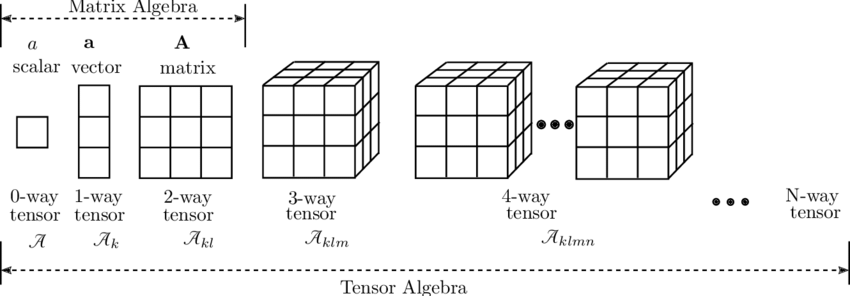

이미지 출처 [researchgate_tensor](https://www.researchgate.net/figure/Tensors-as-generalizations-of-scalars-vectors-and-matrices_fig3_332263806)

# SingleLayer 클래스에 배치 경사 하강법 적용하기

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape)

- 정방향 계산을 행렬 곱셈으로 표현하면 **XW + b**
- 그레디언트는 오차와 입력 데이터의 곱이므로 X^T*E (E는 오차)

In [0]:
#forpass(), backprop() 메서드에 배치 경사하강법 적용
def forpass(self, x):
  z = np.dot(x, self.w) + self.b
  return z


def backprop(self, x, err):
  m = len(x)  #넘파이 배열의 행 크기 반환
  w_grad = np.dot(x.T, err) / m  #가중치에 대한 평균 그레이디언트
  b_grad = np.sum(err) / m  #절편에 대한 평균 그레이디언트
  return w_grad, b_grad

In [0]:
#SingleLayer에서의 fit() 메서드
def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= w_grad
                self.b -= b_grad
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))

In [0]:
#fit() 메서드 수정 (forpass와 backward에서 전체 샘플을 한번에 계산)
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1) #타깃을 (m,1) 크기의 열 벡터로 바꿈(활성화 출력 a가 열벡터이므로)
        y_val = y_val.reshape(-1, 1)
        m = len(x) # 샘플 개수를 저장함
        self.w = np.ones((x.shape[1], 1))
        self.b = 0
        self.w_history.append(self.w.copy())

        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y - a)
            w_grad, b_grad = self.backprop(x, err)
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m #그레디언트에서 패널티 항의 미분 값을 더함
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)

In [0]:
#predict()와 update_val_loss() 메서드도 수정
def predict(self, x):
    z = self.forpass(x)
    return z > 0

def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1, 1)) #예측과 타깃 열 벡터를 비교

In [0]:
#전체 코드는 다음과 같음
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) #클리핑도 일종의 정규화
        a = 1 / (1 + np.exp(-z))
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.w = np.ones((x.shape[1], 1))
        self.b = 0
        self.w_history.append(self.w.copy())

        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y - a)

            w_grad, b_grad = self.backprop(x, err)
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a))) #로그 손실과 규제 손실을 더하여 리스트에 추가
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [0]:
#훈련데이터 표준화 전처리(transform() 메서드)
#StandardScaler 이용 -> 평균 0, 표준편차 1
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [0]:
#SingleLayer 클래스 객체에 배치 경사하강법 적용
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000) #에포크의 기본 값 늘림
single_layer.score(x_val_scaled, y_val)

- 에포크를 늘린 이유는 에포크마다 가중치 업데이트를 하는 횟수에 차이가 있기 때문
- SGD의 경우 샘플 개수 * 에포크 만큼 가중치를 업데이트 함
- BGD의 경우 에포크만큼 가중치를 업데이트 함 

In [0]:
#훈련 손실과 검증 손실을 그래프로 출력
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

=> 손실값이 안정적으로 감소함
- 가중치의 변화가 연속적이니, 손실값도 안정적으로 수렴함

In [0]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

### 다층 퍼셉트론(Multilayer Perceptron, MLP)

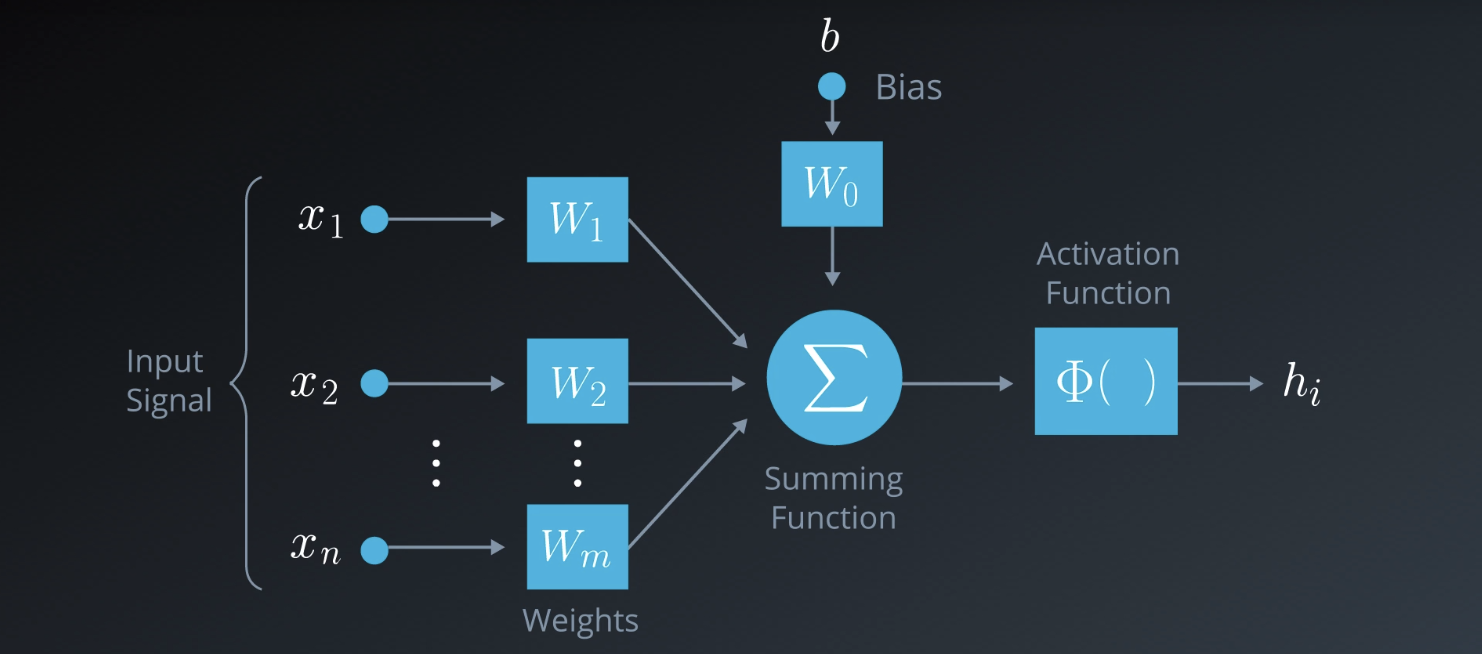

- 입력값은 w에 의해 가중되고 더해짐 + bias를 더함 -> 활성화 함수 거쳐 출력됨
- n개의 입력이 m개의 뉴런으로 입력되는데, 은닉층을 통과한 값들이 출력층에서 합쳐짐 (딥러닝!)
- 최종 예측을 위해서는 출력을 다시 시그모이드 함수에 통과시켜 확률값을 얻어야
- 각 층은 하나 이상의 뉴런을 가지며, 같은 층에 있는 뉴런은 모두 같은 활성화 함수를 사용해야 함
- 신경망에서 하나의 층을 행렬로, 하나의 뉴런을 행렬의 열로 생각할 것
- 즉 층을 많이 쌓았다 = 행렬의 개수가 많다




### 완전연결신경망(Fully-connecte Neural Network)

- 입력층과 은닉층, 은닉층과 출력층 사이의 뉴런이 모두 연결되어있는 신경망
- = 다층 퍼셉트론 = 밀집 연결(densely connected) = feed forward 신경망(데이터의 흐름이 한 쪽 방향으로만 진행됨)

# 2개의 층을 가진 신경망 구현하기

In [0]:
#SingleLayer 클래스를 상속
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units #은닉 층의 뉴런 개수
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

In [0]:
#forpass() 메서드 수정
#은닉층의 활성화함수를 통과한 a1과 출력층의 가중치 w2를 곱, b2를 더해 최종 출력 z2 반환
def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2

In [0]:
#backprop() 메서드 수정
def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

In [0]:
#fit() 메서드 수정
#3개의 작은 메서드(init_weights(), fit(), training())로 쪼갬
def init_weights(self, n_features): #입력 특성의 개수 지정
    self.w1 = np.ones((n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.ones((self.units, 1))
    self.b2 = 0
    
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
        a = self.training(x, y, m)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
        self.losses.append((loss + self.reg_loss()) / m)
        self.update_val_loss(x_val, y_val)
        
def training(self, x, y, m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

In [0]:
#reg_loss() 메서드 수정
def reg_loss(self): #가중치에 규제를 적용함
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [0]:
#전체 코드
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2

    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.ones((self.units, 1))
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.init_weights(x.shape[1])
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

# 모델 훈련하기

In [0]:
#모델 훈련하기
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

In [0]:
#훈련손실과 검증손실 그래프 분석
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

- SingleLayer 클래스보다 가중치의 개수가 훨씬 많아져 학습하는 데 시간이 많이 걸림 -> 손실 그래프가 이전보다 천천히 감소함
- 초기 손실값이 감소하는 곡선이 매끄럽지 않음 -> 가중치 초기화를 개선해야
- train_loss와 val_loss의 차이가 큼 ㅜㅜ

# 가중치 초기화 개선

In [0]:
#시드 설정 후 난수 발생
np.random.seed(0)
np.random.rand(5)

In [0]:
#랜덤한 수로 가중치를 초기화
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

In [0]:
#모델 훈련 후 손실함수 그리기
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 미니배치경사하강법 구현하기
- RandomInitNetwork 클래스를 상속함
- 새로 추가된 batch_size 매개변수만 직접 관리함
- batch_size는 미니 배치의 경우 보통 32~512 사이의 값(2의 배수)을 지정함

In [0]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size

In [0]:
#fit() 메서드 수정하기
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y_val = y_val.reshape(-1, 1)
    self.init_weights(x.shape[1])
    np.random.seed(42)

    for i in range(epochs):
        loss = 0

        for x_batch, y_batch in self.gen_batch(x, y): #batch_size만큼 미니배치를 만들어 반환
            y_batch = y_batch.reshape(-1, 1)
            m = len(x_batch)
            a = self.training(x_batch, y_batch, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
        self.losses.append((loss + self.reg_loss()) / len(x))
        self.update_val_loss(x_val, y_val)

In [0]:
#gen_batch() 메서드 만들기
#-> batch_size만큼씩 x,y 배열을 건너뛰며 미니 배치를 반환함
#파이썬의 generator(iterator 생성 함수)로 구현
def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size: #나누어떨어지지 않으면
        bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
        start = self.batch_size * i
        end = self.batch_size * (i + 1)
        yield x[start:end], y[start:end] #batch_size만큼 슬라이싱하여 반환

In [0]:
#미니배치 경사 하강법 적용하기 #미니 배치의 크기 32
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [0]:
#미니배치 경사 하강법 적용하기 #미니 배치의 크기 128
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 사이킷런을 사용해 다층 신경망 훈련하기

- 분류 작업을 위한 MLPClassifier
- 회귀 작업을 위한 MLPRegressor

In [0]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), #은닉층의 크기 정의
                    activation='logistic', #활성화 함수 지정(기본값은 ReLU)
                    solver='sgd', #경사 하강법 알고리즘의 종류 지정
                    alpha=0.01, #규제 적용(사이킷런에서는 L2규제만 지원, 기본값 0.0001)
                    batch_size=32, #배치 크기(기본값 200)
                    learning_rate_init=0.1, #학습률 초기값
                    max_iter=1000) #에포크 횟수 지정

In [0]:
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)